In [125]:
# IF NOT LAUNCHING WITH GOOGLE COLAB, SET THIS TO FALSE
using_colab = True

In [126]:
# setup for colab
if using_colab:
    # connect google drive to colab
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)
    
    # download packages to google colab
    !pip install matplotlib
    !pip install numpy
    !pip install pandas
    !pip install sklearn
    !pip install shap


# to clean output of cell
from IPython.display import clear_output
clear_output()

In [127]:
# import packages
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import shap

In [128]:
def load_data(data_path):
    data = np.load(data_path, allow_pickle=True)

    X_train = data['X_train']
    X_test = data['X_test']
    y_train = data['y_train']
    y_test = data['y_test']

    return X_train, X_test, y_train, y_test

In [129]:
# define root directory for the script
if using_colab:
    root_dir = '/content/gdrive/MyDrive/oc_projet_4'
else:
    root_dir = 'D:/OpenClassrooms/projet_4'

# define dataset to use
#dataset_name = 'app'
dataset_name = 'app_domain'
#dataset_name = 'app_poly'

In [130]:
# get data
data_path = root_dir + '/data/' + dataset_name + '_train_test_sets' + '.npz'
data = load_data(data_path)
X_train, X_test, y_train, y_test = data

# standardize data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [131]:
# get column names
df_path = root_dir + '/data/' + dataset_name + '.csv'
df = pd.read_csv(df_path)
features = list(df.columns)
features.remove('TARGET')

print('nb_features =', len(features))
print()
for f in features:
    print(f)

nb_features = 244

SK_ID_CURR
NAME_CONTRACT_TYPE
FLAG_OWN_CAR
FLAG_OWN_REALTY
CNT_CHILDREN
AMT_INCOME_TOTAL
AMT_CREDIT
AMT_ANNUITY
AMT_GOODS_PRICE
REGION_POPULATION_RELATIVE
DAYS_BIRTH
DAYS_EMPLOYED
DAYS_REGISTRATION
DAYS_ID_PUBLISH
OWN_CAR_AGE
FLAG_MOBIL
FLAG_EMP_PHONE
FLAG_WORK_PHONE
FLAG_CONT_MOBILE
FLAG_PHONE
FLAG_EMAIL
CNT_FAM_MEMBERS
REGION_RATING_CLIENT
REGION_RATING_CLIENT_W_CITY
HOUR_APPR_PROCESS_START
REG_REGION_NOT_LIVE_REGION
REG_REGION_NOT_WORK_REGION
LIVE_REGION_NOT_WORK_REGION
REG_CITY_NOT_LIVE_CITY
REG_CITY_NOT_WORK_CITY
LIVE_CITY_NOT_WORK_CITY
EXT_SOURCE_1
EXT_SOURCE_2
EXT_SOURCE_3
APARTMENTS_AVG
BASEMENTAREA_AVG
YEARS_BEGINEXPLUATATION_AVG
YEARS_BUILD_AVG
COMMONAREA_AVG
ELEVATORS_AVG
ENTRANCES_AVG
FLOORSMAX_AVG
FLOORSMIN_AVG
LANDAREA_AVG
LIVINGAPARTMENTS_AVG
LIVINGAREA_AVG
NONLIVINGAPARTMENTS_AVG
NONLIVINGAREA_AVG
APARTMENTS_MODE
BASEMENTAREA_MODE
YEARS_BEGINEXPLUATATION_MODE
YEARS_BUILD_MODE
COMMONAREA_MODE
ELEVATORS_MODE
ENTRANCES_MODE
FLOORSMAX_MODE
FLOORSMIN_MODE


#### Load final model and set the decision threshold (optimized threshold from the previous notebook)

In [132]:
# load final model
model_save_name = 'LogisticRegression_final'

model_save_path = root_dir + '/models/' + model_save_name + '.pkl'
with open(model_save_path, 'rb') as f:
    model = pickle.load(f)

print(model.get_params)

<bound method BaseEstimator.get_params of LogisticRegression(class_weight='balanced', max_iter=1000, penalty='none')>


In [133]:
# from "optimize_final_model" notebook
decision_threshold = 0.505

In [134]:
# get predictions of model on test set
y_proba = np.delete(model.predict_proba(X_test), 0, axis=1)
y_pred = np.where(y_proba >= decision_threshold, 1, 0).ravel()

#### Shap initialization

(244,) 



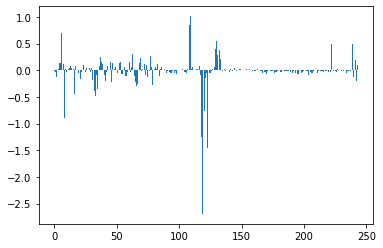

In [ ]:
# get coefficents of model
importance = model.coef_[0]
print(importance.shape, '\n')

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [ ]:
# create shap explanier
explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)
print(shap_values.shape)

(92254, 244)


In [ ]:
explainer.expected_value

-0.416848795267401

In [ ]:
# nb features to show in graphs
nb_features = 10

## We start with the global interpretation
### (i.e. which features were important during the model training)

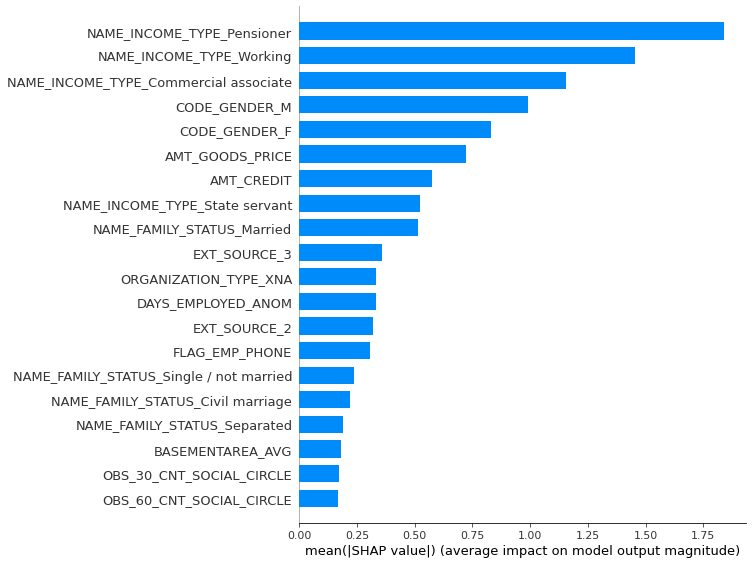

In [ ]:
shap.summary_plot(shap_values, X_test, feature_names=features, plot_type='bar')

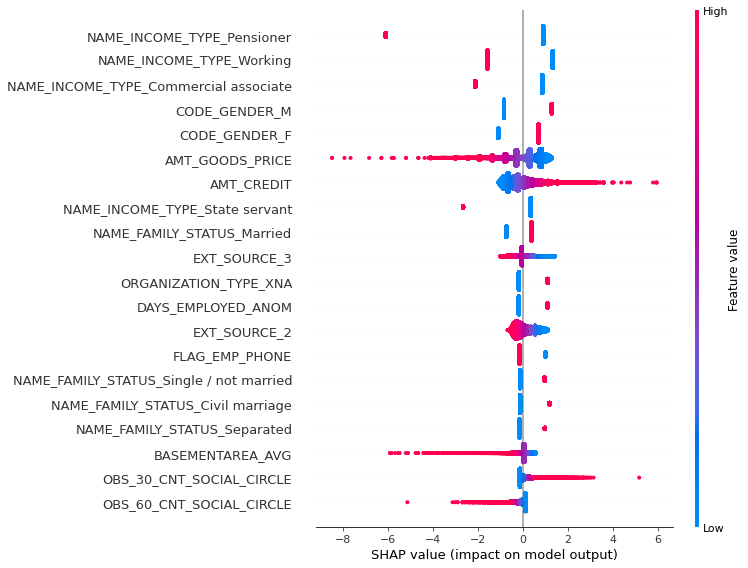

In [ ]:
shap.summary_plot(shap_values, X_test, feature_names=features)

## Now, the local interpretation
### (i.e. what are the decisive features the model uses to make a prediction on a particular individual)

#### First let's see what features are most used when making the correct prediction that a client will repay

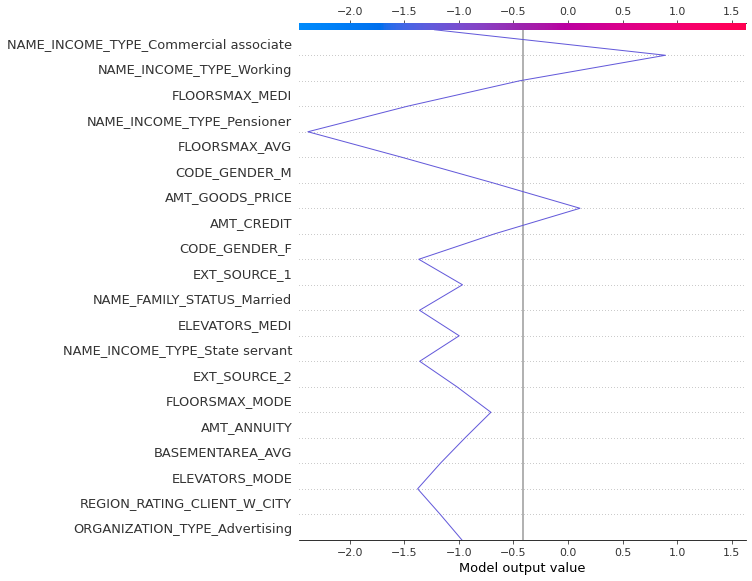

In [ ]:
# select a correct negative prediction (the client has repaid)

while True:
    row_id = np.random.randint(y_test.shape[0])
    print('index:', row_id)
    print('label:', y_test[row_id])
    print('prediction:', y_pred[row_id])

    if (y_test[row_id] == 0) and (y_pred[row_id] == 0):
        break


shap.decision_plot(explainer.expected_value, 
                   shap_values[row_id], 
                   feature_names=features)

#### Now let's see what happens when making the correct prediction that a client will NOT repay

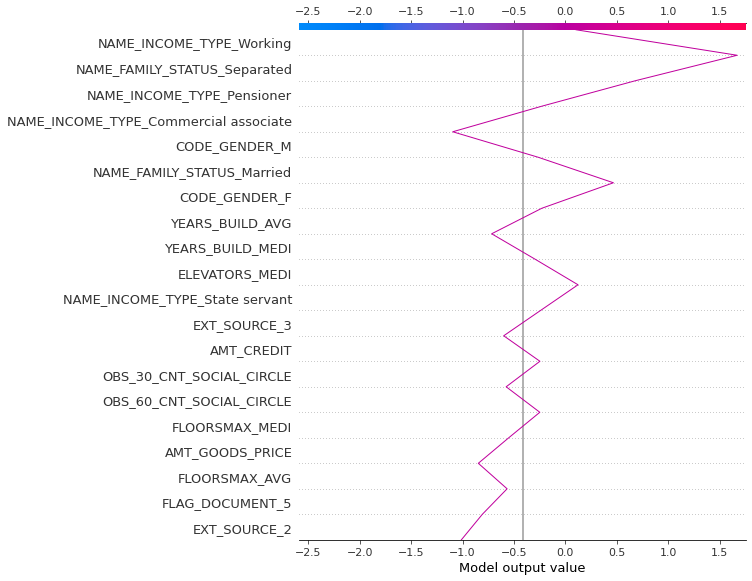

In [ ]:
# select a correct positive prediction (the client hasn't repaid)

while True:
    row_id = np.random.randint(y_test.shape[0])

    if (y_test[row_id] == 1) and (y_pred[row_id] == 1):
        print('index:', row_id)
        print('label:', y_test[row_id])
        print('prediction:', y_pred[row_id])
        break


shap.decision_plot(explainer.expected_value, 
                   shap_values[row_id], 
                   feature_names=features)

### For "debugging" we could see what features are important when the model is wrong<br>(false positives or false negatives)

#### False positives

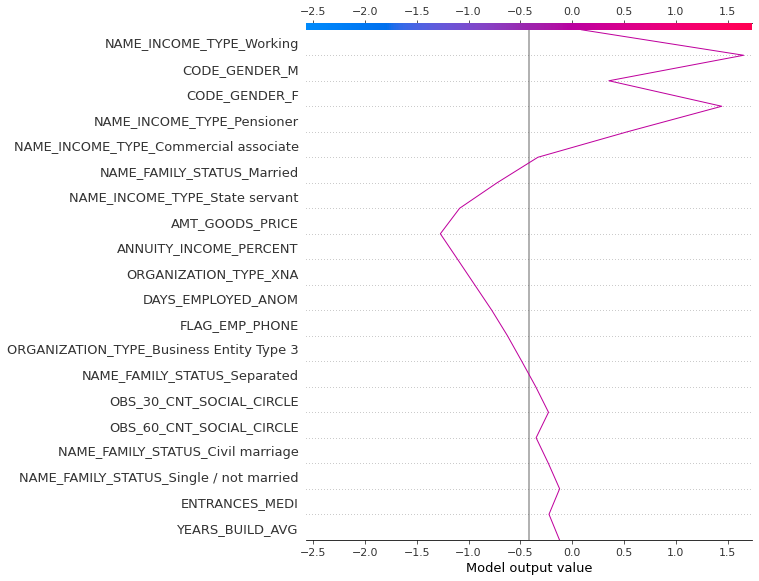

In [ ]:
# false positive (a "good" client predicted as "bad")

while True:
    row_id = np.random.randint(y_test.shape[0])

    if (y_test[row_id] == 0) and (y_pred[row_id] == 1):
        print('index:', row_id)
        print('label:', y_test[row_id])
        print('prediction:', y_pred[row_id])
        break


shap.decision_plot(explainer.expected_value, 
                   shap_values[row_id], 
                   feature_names=features)

#### False negative

index: 21457
label: 1
prediction: 0


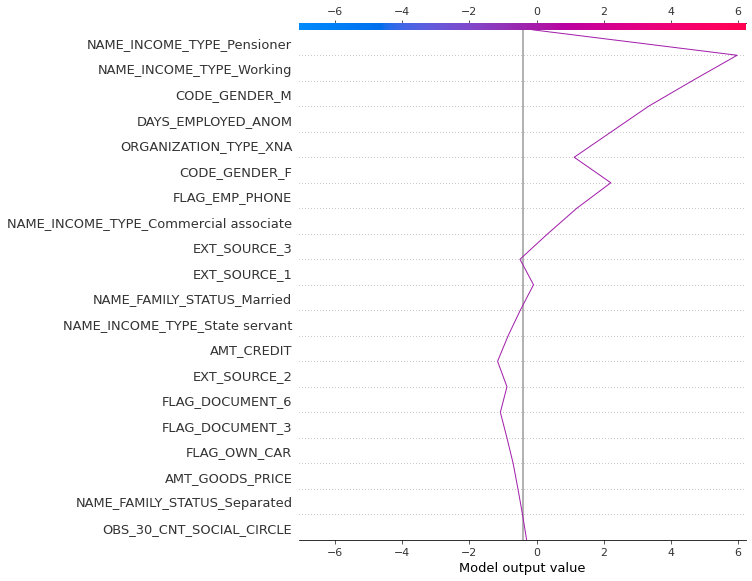

In [ ]:
# false negative (a "bad" client predicted as "good")

while True:
    row_id = np.random.randint(y_test.shape[0])

    if (y_test[row_id] == 1) and (y_pred[row_id] == 0):
        print('index:', row_id)
        print('label:', y_test[row_id])
        print('prediction:', y_pred[row_id])
        break


shap.decision_plot(explainer.expected_value, 
                   shap_values[row_id], 
                   feature_names=features)